# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

#### Data Setup

In [1]:
import pandas as pd

df = pd.read_csv('data/human_body_temperature.csv')

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

Use Seaborn style for graphic representation

In [3]:
sns.set()

Review columns info and understanding the shape of the sample set. It has 130 rows and 3 columns

In [4]:
print(df.info())
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 3 columns):
temperature    130 non-null float64
gender         130 non-null object
heart_rate     130 non-null float64
dtypes: float64(2), object(1)
memory usage: 3.1+ KB
None
(130, 3)


#### Question 1

Use graphical method by plotting the temperature data against a random sample normal distributed dataset in CDF form

In [5]:
# Rule of thumb is to set bins as the square root of the numbers of data points
bins = np.sqrt(len(df)).astype('int')
print(bins)

11


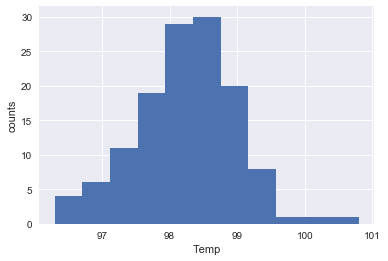

In [6]:
_ = plt.hist('temperature', data=df, bins=bins)
_ = plt.xlabel('Temp')
_ = plt.ylabel('counts')

Initial view suggests that data are normally distributed. We need to further confirm that by drawing a normal distributed samples from numpy

In [7]:
mu = np.mean(df.temperature)
sigma = np.std(df.temperature)
samples = np.random.normal(mu, sigma, 10000)

In [8]:
# Create a function to save typing time
def ecdf(data):
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x, y

In [9]:
x, y = ecdf(df.temperature)
x_theor, y_theor = ecdf(samples)

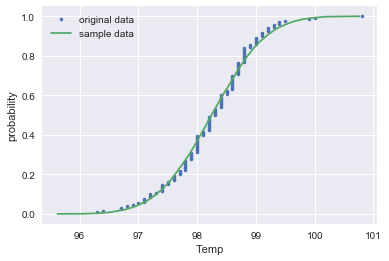

In [10]:
_ = plt.plot(x, y, marker='.', linestyle='none', label='original data')
_ = plt.plot(x_theor, y_theor, label='sample data')
_ = plt.xlabel('Temp')
_ = plt.ylabel('probability')
_ = plt.legend(loc='best')
plt.show()

The CDF curve for the dataset matches pretty well with the normal distributed sample set CDF.
We can conclude that the data collected are normal distributed.

#### Question 2

Per [t-distribution table](http://www.sthda.com/english/wiki/t-distribution-table) , a sample size need to be at least 25-30 to achieve normal distribution. Sample size >120 will have very similar distribution shape as infinite sample size. The dataset in this exercise has 130 samples. We can assume that the data are normal distributed.

If the data were collected from babies or small children, the dependent variable will be ages. If the data were collected from a gym, the dependent variable will be level of exercising. Since there is no specific information with regarding the conditions on how the data were collected, we assume that observations are independent. 

#### Question 3

Null Hypothesis - Sample mean is equal to mean population temperature of 98.6F

First shifted the sample mean to be equal to that of the population temperature mean

In [11]:
sample_mean = np.mean(df.temperature)
sample_shifted = df.temperature - sample_mean + 98.6

Create a function on drawing bootstrap samples

In [12]:
def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

Then, create another function to generate many bootstrap replicates 

In [13]:
def draw_bs_reps(data, func, size):
    bs_replicates = np.empty(size)
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)
    return bs_replicates

Get the set of means for the 10000 bootstrap replicates

In [14]:
bs_replicates = draw_bs_reps(sample_shifted, np.mean, 10000)

Identify the 95% confident interval among the bs_replicates and p-value

In [15]:
print(np.percentile(bs_replicates, [2.5, 97.5]))

[98.47769231 98.72615385]


In [16]:
p = np.sum(bs_replicates <= sample_mean)/len(bs_replicates)
print(p)

0.0


From the 95% interval range, it does not contain 98.6F, which mean that there is less than 5% chance of getting 98.6F as a mean to the sample population. In fact, the chance of getting the sample_mean is zero. 

We will reject the null hypothesis that the sample mean is equal to the population mean of 98.6F. This implies two possibilities:
1. Population temperature mean is not 98.6F
2. Sample data are not representative to true population

Given the large sample set, z test is used

In [17]:
z = (sample_mean -98.6)/ (np.std(df.temperature) / np.sqrt(len(df)))
print(z)

-5.475925202078116


The z score is > 3, which mean the sample mean is more than 3 standard deviation away from the null hypothesis mean of 98.6F. It suggest significant evidence to reject the null hypothesis.

#### Question 4

Null Hypothesis - Sample mean is equal to mean population temperature of 98.6F

Drawing ten sample from the dataset and repeat all the steps that were run in step 3

In [18]:
ten_sample = df['temperature'].sample(n=10, random_state=3)

In [19]:
ten_sample_mean = np.mean(ten_sample)
ten_sample_shifted = ten_sample - sample_mean + 98.6
bs_replicates_1 = draw_bs_reps(ten_sample_shifted, np.mean, 10000)
print(np.percentile(bs_replicates, [2.5, 97.5]))
p = np.sum(bs_replicates_1 <= ten_sample_mean)/len(bs_replicates_1)
print(p)

[98.47769231 98.72615385]
0.0444


The p-value is not zero as in question 3, but it is still small enough to reject the null hypothesis.

Given the small sample size, a t-test will be applied

In [20]:
t = (ten_sample_mean- 98.6)/(np.std(ten_sample)/ np.sqrt(10))
print (t)

-2.3267002029883948


t-score of 2.32 is between 2% & 5% alpha. If the confident level is 95%, it is not significant to reject the null hypothesis.